## **TD 11 et 12 - Collecte, Traitement, et Analyse de données de réseaux sociaux**

##### *LEFEVRE Laura et LE CORRE Camille - LDD BI*

![Alt text](Schema_InPoDa.png)

### I- Traitement des données

Dans cette première partie, nous récupérons les données, nous les nettoyons et les organisons, pour obtenir un DataFrame contenant les données qui nous intéressent pour la suite du projet.

In [1]:
# Importation des différents modules utilisés dans notre programme

import json
import re
import pandas as pd
import os
import random as rd
from textblob import TextBlob
import matplotlib as plt
import matplotlib.pyplot
import numpy as np

Dans un premier temps, on définit une classe qui va contenir une fonction permettant de récupérer dans une variable, la liste des dictionnaires représentant les différents tweets contenu dans le fichier json.

In [14]:
class reader :
    '''Classe permettant la lecture de fichier contenant les tweets'''

    def openFile(fileName):
        '''Fonction qui permet de lire et de recuperer un fichier json dans une variable data_dict'''
        
        with open(fileName, encoding='utf8') as json_data:
            data_dict = json.load(json_data)
            
            return data_dict

Par exemple, la commande suivante permet de récupérer dans la varible dic_tweets, la liste des tweets du fichier "versailles_tweets_100.json". On obtient une liste de dictionnaire et dic_tweets[0] nous permet de visualiser le premier tweet. On peut voir qu'il possède plusieurs éléments qui ne vont pas nous servir. Nous allons donc pouvoir nettoyer chacun des tweets, en gardant les informations essentielles (author_id, text, hastags...). De plus, on va pouvoir nettoyer le texte du tweet en supprimant tous les caractères spéciaux.

In [16]:
dic_tweets = reader.openFile("versailles_tweets_100.json")

# Exemple affichage 1er tweet
dic_tweets[0]

{'_id': '1421616335700824064',
 'public_metrics': {'retweet_count': 0,
  'reply_count': 0,
  'like_count': 1,
  'quote_count': 0},
 'id': '1421616335700824064',
 'conversation_id': '1421616335700824064',
 'author_id': '1339914264522461187',
 'text': 'Goumin des éléphants joueurs la même fatigue même 😫 #twitter225',
 'geo': {'place_id': '00b8943291443c8c'},
 'lang': 'fr',
 'created_at': '2021-07-31T23:38:41.000Z',
 'entities': {'hashtags': [{'start': 52, 'end': 63, 'tag': 'twitter225'}]}}

On code les fonctions permettant le nettoyage :

1. Supprimer les emojis

In [4]:
def removeEmojis(data):
    '''Fonction qui permet de supprimer les emojis du text d'un tweet 
    (source : https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)'''
    
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

2. Supprimer tous les caractères spéciaux

In [25]:
def cleanText(text):
    '''Fonction qui permet de nettoyer le texte d'un tweet a l'aide de regex'''
    
    text = text.lower()
    text = removeEmojis(text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', "", text)                            # suppression des URL
    text = re.sub(r'@([A-Za-z0-9_]+)', "", text)                                # suppresion des mentions
    text = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", text)
    text = re.sub(r"#([A-Za-z0-9_]+)", "", text)                                # suppresion des hashtags
    text = re.sub(r"[\,\!\?\%\(\)\/\"\&\+\#\$\£\%\:\.\@\-\n]", "", text)
    text = re.sub(r"[\é\è\ê]", "e", text)
    text = re.sub(r"[\ù]", "u", text)
    text = re.sub(r"[\à]", "a", text)
    text = re.sub(r"[\î\ï]", "i", text)
    text = re.sub(r"( )+", " ", text)
    text = re.sub(r"( )*$", "", text)
    text = re.sub(r"^( )", "", text)
    
    return text

Il faut maintenant créer la zone d'atterrissage des tweets. 
On crée donc une fonction qui va nous permettre d'ajouter les tweets dans un autre fichier (zone_atterrissage.json), semblable à l'initial, mais avec les textes des tweets nettoyés. 

In [26]:
def zoneAtterrissage(tweet):
    '''Fonction qui permet de creer la zone d'atterrisage des tweets. Elle ajoute dans un fichier zone d'atterrissage, un tweet en le nettoyant.'''
    
    # Nettoie le texte du tweet et remplace le texte initiale par le texte nettoye
    tweet_clean = cleanText(tweet['text'])
    tweet['text'] = tweet_clean
    
    # Si le fichier de la zone d'atterrissage n'existe pas, on le creer et on y ajoute le tweet
    if os.path.exists("zone_atterrissage.json") == False:
        with open("zone_atterrissage.json", "w") as fil:
            json.dump([tweet], fil)
    
    # Sinon, on recupere les tweets deja presents, et on y ajoute celui en cours de traitement
    else :
        li_tweet = reader.openFile("zone_atterrissage.json")
        with open("zone_atterrissage.json", 'w') as filout :
            li_tweet.append(tweet)
            json.dump(li_tweet, filout)
            
    return
       

Il nous faut à présent une fonction qui va nous permettre de traiter les tweets que l'on a à disposition. On va donc envoyer chaque tweet dans la zone d'atterrissage, l'un après l'autre.

In [7]:
def traitement_nettoyage(liste_tweet:list):
    '''Cette fonction permet de traiter tous les tweets et de les envoyer dans la zone d'atterrissage'''

    for elt in liste_tweet:
        zoneAtterrissage(elt)
    
    return

On execute cette méthode en passant en paramètre le fichier json contenant les tweets. Après l'exécution on obtient un nouveau fichier json avec les tweets nettoyés.

In [8]:
traitement_nettoyage(dic_tweets)

A présent, tous les tweets sont stockés dans un nouveau fichier (zone_atterrissage.json). Ils sont nettoyés et on va pouvoir créer une zone d'entrepot, sous forme de DataFrame. On va y stocker tous les tweets avec seulement les informations dont on a besoin.
On va donc créer une classe contenant un certain nombre de fonctions qui vont nous permettre de récupérer ces informations. 

On va avoir des fonctions qui permettent d'extraire le texte, les hashtags, les mentions, le topic, et d'attribuer un sentiment au tweet.

In [29]:
class extract:
    '''Classe permettant de récupérer les informations d'un tweet'''

    def authorExtract(tweet):
        '''Fonction qui retourne l'id de l'auteur du tweet'''
        return str(tweet.get("author_id"))

    def textExtract(tweet):
        '''Fonction qui retourne le text d'un tweet'''

        # On recupere le texte
        text = tweet.get("text")

        # S'il n'y a pas de text (exemple : c'etait une mention), on retourne None
        if text == '':
            return
        
        return text


    def listHashtags(tweet):
        ''' Fonction qui renvoie la liste de hashtags d'un tweet.
        Cette fonction est utilisée dans la fonction ZoneEntrepot '''

        list_hashtags = []
        if "entities" in tweet:
            if "hashtags" in tweet["entities"]:                # on vérifie qu'il y a au moins un hashtag
                for h in range(len(tweet["entities"]["hashtags"])):            # on parcourt la liste des hashtags
                    list_hashtags.append(tweet["entities"]["hashtags"][h]["tag"])   
                
                return list_hashtags
        
        return


    def listMentionedUsers(tweet):
        ''' Fonction qui renvoie la liste des utilisateurs mentionnés dans un tweet.
        Cette fonction est utilisée dans la fonction ZoneEntrepot '''

        list_mentioned_users = []
        
        if "entities" in tweet:
            if "mentions" in tweet["entities"]:                # on vérifie qu'il y a au moins un utilisateur mentionné
                for m in range(len(tweet["entities"]["mentions"])):            # on parcourt la liste des utilisateurs mentionnés
                    list_mentioned_users.append(tweet["entities"]["mentions"][m]["username"])
                
                return list_mentioned_users
        return


    def topic(tweet):
        ''' Fonction qui attribue un topic à un tweet de façon aléatoire.
        Cette fonction est utilisée dans la fonction ZoneEntrepot '''
        
        topics = ['sport', 'politic', 'environment', 'TV', 'animal', 'nature', 'celebrity',
                                    'travel', 'singing', 'love', 'fun', 'history', 'culture']
        
        if tweet.get('text') != '':             # si le tweet contient un texte
            return rd.choice(topics)            # on va lui attribuer un topic
        
        return                                  # sinon, aucun topic n'est attribué 

    
    def feeling(tweet):
        ''' Fonction qui détermine le sentiment d'un tweet (positif, négatif ou neutre).
        Cette fonction est utilisée dans la fonction ZoneEntrepot '''
        
        feeling = TextBlob(tweet.get("text")).sentiment
        
        if feeling[0] < 0:
            return "negative"
        elif feeling[0] == 0:
            return "neutral"
        else:
            return "positive"


Après avoir déclaré toutes ces fonctions, on peut créer la fonction zoneEntrepot pour créer un DataFrame contenant les tweets avec les informations des fonctions précédentes. Chaque tweet va correspondre à une ligne.

In [30]:
def zoneEntrepot(list):
    '''Fonction qui prend en entrée la liste des dictionnaires correspondant
    aux tweets issus du fichier zone_atterrissage.json et qui créer un DataFrame
    contenant uniquement les informations qui nous intéressent'''

    # Création d'un DataFrame
    zone_entrepot = pd.DataFrame(columns = ['author_id', 'text', 'hashtags', 'mentioned_users', 'topics', 'feelings'])

    for k in range(len(list)):        # on travaille sur un tweet à la fois
        # Création d'une liste qui va contenir toutes les informations utiles de ce tweet
        tweet = []
        
        # Ajout à cette liste des informations récupérées de la zone d'atterissage
        tweet.extend([extract.authorExtract(list[k]), extract.textExtract(list[k]), extract.listHashtags(list[k]), extract.listMentionedUsers(list[k]), extract.topic(list[k]), extract.feeling(list[k])])
        
        # Ajout de la ligne correspondant au tweet à notre DataFrame
        zone_entrepot.loc[k+1] = tweet

    return zone_entrepot    

On va donc stocker dans une variable la liste des tweets présents dans le fichier zone_atterrissage pour pouvoir créer notre dataFrame à partir des tweets nettoyés. 

In [31]:
#On recupere la liste des tweets
liste_tweet = reader.openFile("zone_atterrissage.json")

#On stocke dans une variable le dataFrame contenant les tweets et les informations sur les tweets que l'on souhaite garder
zone_entrepot_tweet = zoneEntrepot(liste_tweet)

zone_entrepot_tweet  #Affichage du df

,author_id,text,hashtags,mentioned_users,topics,feelings
1,1339914264522461187,goumin des elephants joueurs la meme fatigue meme,[twitter225],None,politic,neutral
2,1339914264522461187,mes tontons vous avez fait votre part jo proch...,"[SupportriceMazo, domie, CIV]","[ericbailly24, maxigr04del]",animal,neutral
3,1339914264522461187,ah oui le sommeil la sera complique est elimin...,[CIV],None,animal,neutral
4,1339914264522461187,juillet journee internationale de la femme afr...,[jifa],None,history,neutral
5,717025418,le pedigree,None,None,TV,neutral
6,992904738516717570,vous avez tt a fait raison le silence incompre...,None,"[isabelle170516, leonna_julie, Steiner2502]",sport,positive
7,992904738516717570,la grande muette continue et continuera de le ...,None,"[LynLyna12, leonna_julie]",love,neutral
8,736523371,under wsh,None,None,environment,neutral
9,1471684208,les bains d'apollon a château de versailles,"[versailles, nocturne, appollon]",None,celebrity,neutral
10,992904738516717570,le rdv aujourd'hui aura tenu ses promesses pou...,None,[leonna_julie],celebrity,neutral


### II - Analyse des données

Maintenant que nos tweets ont été nettoyés et que nous avons un DataFrame contenant uniquement les informations qui nous intéressent, nous allons pouvoir analyser et effectuer des statistiques sur nos tweets.

Tout d'abord, nous cherchons à obtenir les utilisateurs publiant le plus de tweets, les hashtags ou les mentions les plus utilisés, ou bien les topics les plus répandus. Les fonctions suivantes vont permettre à l'utilisateur de connaître le "Top k" parmi ces informations, où k est un nombre choisi par ce dernier.

Les deux fonctions suivantes seront utilisées pour obtenir les tops k :

In [33]:
def listColumn(df, column:str, type_col:str):
    ''' Fonction qui renvoie les éléments d'une colonne d'un DataFrame sous forme d'une liste'''

    if type_col == 'int' or type_col == 'str':           # si la colonne contient des entiers ou une chaîne de caractères
        return list(df[column])
    
    elif type_col == 'list':                             # si la colonne contient des listes (une liste de hashatgs
                                                        # ou d'utilisateurs mentionnés par exemple)
        l_lists = list(df[column])
        l_elem = []
        for i in l_lists:
            if i != None:                               # on ne s'occupe pas des éléments None
                for j in i:
                    l_elem.append(j)
                    
        return l_elem

In [34]:
# Exemple de l'utilisation de la fonction ListColumn : affichage des hashtags des tweets
print(listColumn(zone_entrepot_tweet, "hashtags", 'str'))

[['twitter225'], ['SupportriceMazo', 'domie', 'CIV'], ['CIV'], ['jifa'], None, None, None, None, ['versailles', 'nocturne', 'appollon'], None, None, None, None, None, None, None, None, None, None, None]


In [35]:
def nbOccurencesIntoDict(list_column):
    ''' Fonction qui crée un dictionnaire dans lequel chaque clé correspond à un utilisateur
    ou un hashtag etc, et chaque valeur correspond au nombre d'occurrences de cet élément dans la liste'''

    dic = {}

    for elem in list_column:                # on parcourt la liste de tous les éléments d'une colonne
        # Si on a déjà rencontré cet élément, on incrémente son nombre d'occurences de 1
        if elem != None :
            if elem in dic:                     
                dic[elem] += 1
            # Si on ne l'a jamais rencontré encore, on ajoute une clé               
            else:
                dic[elem] = 1

    return dic

In [36]:
# Exemple de l'utilisation de la fonction nbOccurencesIntoDict avec les utilisateurs mentionnés
print(nbOccurencesIntoDict(listColumn(zone_entrepot_tweet, 'mentioned_users', 'list')))

{'ericbailly24': 1, 'maxigr04del': 1, 'isabelle170516': 1, 'leonna_julie': 3, 'Steiner2502': 1, 'LynLyna12': 1, 'miliemelo82': 1, 'kilianbridoux': 1, 'LeMeneec': 1, 'Polo82810715': 1, 'lrestistant73': 1, 'Pauluskupa': 1, 'anniemacmanus': 2, 'yebbasmith': 1, 'AzmiAnees3': 1}


Les quatres fonctions suivantes permettent de trier les hashtags, les utilisateurs, les utilisateurs mentionnés ou bien les topics, que l'on retrouve le plus de fois dans la colonne du DataFrame correspondante, à celui qu'on retrouve le moins de fois.

1. Pour les hashtags

In [37]:
def sortHashtags(df):
    ''' Fonction renvoyant une liste des hashtags triés en fonction
    du nombre de fois qu'ils ont été utilisés'''

    # On créer un dictionnaire contenant comme clés les différents hashtags
    # et comme valeur le nombre de fois que chaque hashtag a été utilisé
    dic_occurences = nbOccurencesIntoDict(listColumn(df, 'hashtags', 'list'))

    # On trie le dictionnaire par ordre croissant des valeurs et on le transforme en liste
    l = list(sorted(dic_occurences, key=dic_occurences.get, reverse=True))
    if None in l:
        del l[None]
        
    return l

2. Pour les utilisateurs

In [38]:
def sortUsers(df):
    ''' Fonction renvoyant une liste des utilisateurs triés en fonction
    du nombre de fois qu'ils ont publié un tweet'''

    # On créer un dictionnaire contenant comme clés les différents utilisateurs et
    # comme valeur le nombre de tweets qu'ils ont publié
    dic_occurences = nbOccurencesIntoDict(listColumn(df, 'author_id', 'int'))

    # On trie le dictionnaire par ordre croissant des valeurs et on le transforme en liste
    l = list(sorted(dic_occurences, key=dic_occurences.get, reverse=True))

    return l

3. Pour les utilisateurs mentionés

In [39]:
def sortMentionedUsers(df):
    ''' Fonction renvoyant une liste des utilisateurs mentionnés
    triés en fonction du nombre de mentions'''

    # On créer un dictionnaire contenant comme clés les différents utilisateurs
    # mentionnés et comme valeur le nombre de fois qu'ils ont été mentionés
    dic_occurences = nbOccurencesIntoDict(listColumn(df, 'mentioned_users', 'list'))

    # On trie le dictionnaire par ordre croissant des valeurs et on le transforme en liste
    l = list(sorted(dic_occurences, key=dic_occurences.get, reverse=True))

    return l

4. Pour les topics

In [40]:
def sortTopics(df):
    ''' Fonction renvoyant une liste des topics triés en fonction
    du nombre de fois qu'ils ont été utilisés'''

    # On créer un dictionnaire contenant comme clés les différents
    # topics et comme valeur le nombre de tweets sur ce topic
    dic_occurences = nbOccurencesIntoDict(listColumn(df, 'topics', 'str'))

    if None in dic_occurences:
        del dic_occurences[None]

    # On trie le dictionnaire par ordre croissant des valeurs et on le transforme en liste
    l = list(sorted(dic_occurences, key=dic_occurences.get, reverse=True))

    return l

In [41]:
# Exemple d'utilisation de la fonction sortMentionedUsers
sortMentionedUsers(zone_entrepot_tweet)

# En effet, comme vu à l'exemple précédent, 'leonna_julie' est la personne qui a été mentionnée
# le plus de fois (3 fois). Ensuite, c'est 'anniemacmanus', qui a été mentionné 2 fois, et ainsi de suite.

['leonna_julie',
 'anniemacmanus',
 'ericbailly24',
 'maxigr04del',
 'isabelle170516',
 'Steiner2502',
 'LynLyna12',
 'miliemelo82',
 'kilianbridoux',
 'LeMeneec',
 'Polo82810715',
 'lrestistant73',
 'Pauluskupa',
 'yebbasmith',
 'AzmiAnees3']

Ces quatre fonctions sont utilisées dans la fonction qui suit, permettant à l'utilisateur de connaitre le Top k qu'il souhaite. 

In [42]:
def topK(df):
    ''' Fonction qui demande à l'utilisateur le Top k qu'il souhaite connaitre,
    ainsi que ce nombre k, puis qui renvoie ce classement demandé'''

    possible_top = ('H', 'U', 'UM', 'T')
    top = 0
    k = -1

    # On demande à l'utilisateur le Top qu'il souhaite connaitre
    while top not in possible_top:
        top = input("Quel Top voulez-vous connaitre ? hashtags (tapez H), utilisateurs (tapez U), utilisateurs mentionnés (tapez UM) ou bien topics (tapez T) ?")
    
    # Utilisation des fonctions de tri par ordre croissant des colonnes
    # du DataFrame en fonction du choix de l'utilisateur
    if top == 'H':
        l = sortHashtags(df)
    elif top == 'U':
        l = sortUsers(df)
    elif top == 'UM':
        l = sortMentionedUsers(df)
    else:
        l = sortTopics(df)

    # Nombre maximum que l'utilisateur pourra entrer pour la valeur de k
    k_max = len(l)

    # Choix de la valeur k par l'utilisateur
    k = int(input("Veuillez saisir k : "))
    while (k < 0) or (k > k_max):
        k = int(input("Veuillez saisir k : "))
    
    return l[:k]

Pour tester cette fonction et connaître le top k de votre choix, vous pouvez executer la cellule suivante et vous laisser guider par les instructions :

In [43]:
topK(zone_entrepot_tweet)

['leonna_julie', 'anniemacmanus', 'ericbailly24']

Maintenant, nous cherchons à analyser le nombre de publications par utilisateur, par hashtag ou bien par topic. Pour cela, nous commençons par trier nos éléments en fonction du nombre de publications dans lesquelles ils apparaissent. Ensuite, pour visualiser nos résultats, nous utilisons la bibliothèque Matplotlib, afin d'obtenir des diagrammes.

1. Nombre de publications par utilisateur

In [44]:
def nbPublicationsPerUser(df):
    ''' Fonction qui affiche un diagramme correspondant au nombre de tweets
    publiés par utilisateur'''

    list_nb_publications = list(nbOccurencesIntoDict(listColumn(zone_entrepot_tweet, 'author_id', 'int')).values())
    list_users = list(nbOccurencesIntoDict(listColumn(zone_entrepot_tweet, 'author_id', 'int')).keys())
    x=np.arange(len(list_nb_publications))
    
    plt.pyplot.bar(x, list_nb_publications)

    plt.pyplot.xticks(x, list_users, rotation = 'vertical')
    plt.pyplot.yticks(list_nb_publications)

    plt.pyplot.xlabel("Utilisateurs")
    plt.pyplot.ylabel("Nombre de publications")
    plt.pyplot.title("Diagramme du nombre de publications de chaque utilisateur")

    plt.pyplot.savefig("nb_publications_par_utilisateur.png", bbox_inches="tight", dpi=200)

Affichage du diagramme du nombre de publications par utilisateur :

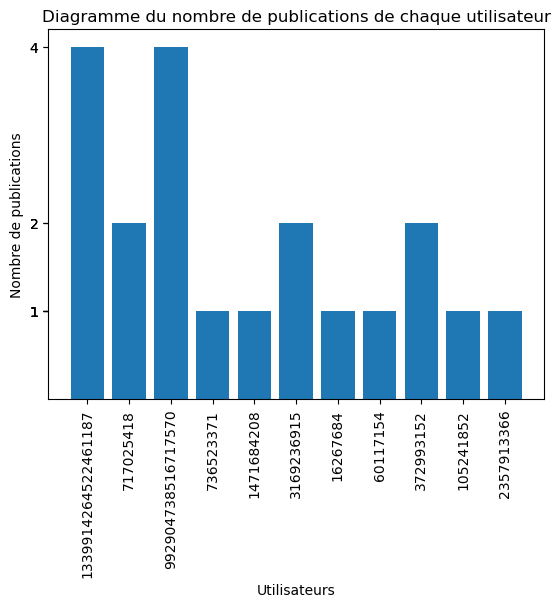

In [45]:
nbPublicationsPerUser(zone_entrepot_tweet)

2. Nombre de publications par hashtag

In [46]:
def nbPublicationsPerHashtag(df):
    ''' Fonction qui affiche un diagramme correspondant au nombre d'apparition pour chaque hashtag'''

    list_nb_publications = list(nbOccurencesIntoDict(listColumn(zone_entrepot_tweet, 'hashtags', 'list')).values())
    list_hashtags = list(nbOccurencesIntoDict(listColumn(zone_entrepot_tweet, 'hashtags', 'list')).keys())
    x=np.arange(len(list_nb_publications))
    plt.pyplot.bar(x, list_nb_publications)

    plt.pyplot.xticks(x, list_hashtags, rotation = 'vertical')
    plt.pyplot.yticks(list_nb_publications)
    
    plt.pyplot.xlabel("Hashtags")
    plt.pyplot.ylabel("Nombre de publications")
    plt.pyplot.title("Diagramme du nombre de publications par hashtag")

    plt.pyplot.savefig("nb_publications_par_hashtag.png", bbox_inches="tight", dpi=200)

Affichage du diagramme du nombre de publications par hashtag :

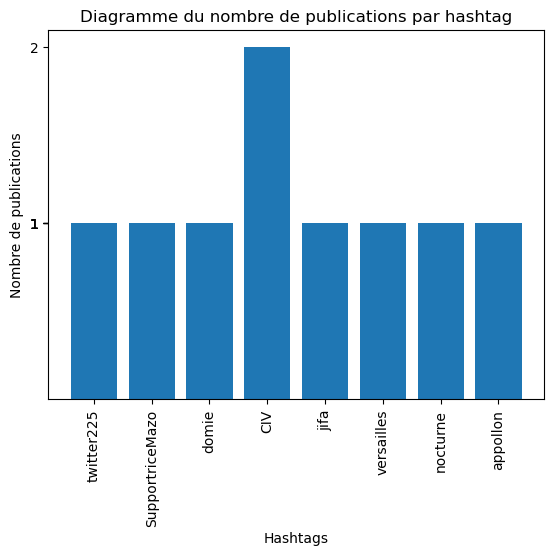

In [47]:
nbPublicationsPerHashtag(zone_entrepot_tweet)

3. Nombre de publications par topic

In [48]:
def nbPublicationsPerTopic(df):
    ''' Fonction qui affiche un diagramme correspondant au nombre de tweets par topic'''

    list_nb_publications = list(nbOccurencesIntoDict(listColumn(zone_entrepot_tweet, 'topics', 'str')).values())
    list_topics = list(nbOccurencesIntoDict(listColumn(zone_entrepot_tweet, 'topics', 'str')).keys())
    x=np.arange(len(list_nb_publications))
    
    plt.pyplot.bar(x, list_nb_publications)

    plt.pyplot.xticks(x, list_topics, rotation = 'vertical')
    plt.pyplot.yticks(list_nb_publications)

    plt.pyplot.xlabel("Topics")
    plt.pyplot.ylabel("Nombre de publications")
    plt.pyplot.title("Diagramme du nombre de publications par topic")

    plt.pyplot.savefig("nb_publications_par_topic.png", bbox_inches="tight", dpi=200)

Affichage du diagramme du nombre de publications par topic :

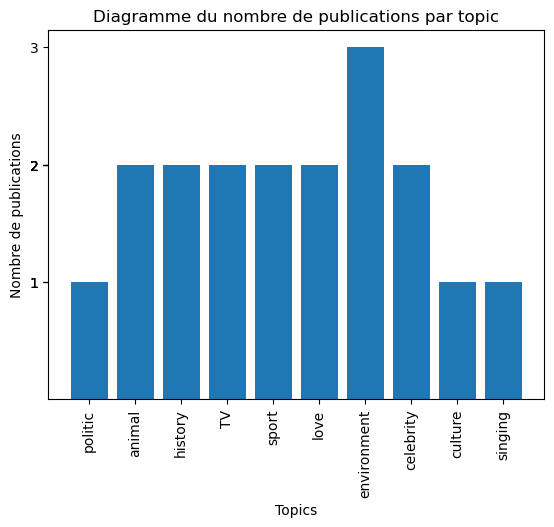

In [49]:
nbPublicationsPerTopic(zone_entrepot_tweet)

On peut ensuite définir un certain nombre de foncions sur des utilisateurs, mentions et hashtags spécifiques.

1. La liste des tweets d'un utilisateur

In [50]:
def tweetByUser():
    '''Fonction qui permet de renvoyer les tweets postés par un utilisateur spécifique'''

    li_user = listColumn(zone_entrepot_tweet, 'author_id', 'str')   #On récupère la liste des utilisateurs
    li_text = listColumn(zone_entrepot_tweet, 'text', 'str')        #On récupère la liste des textes des tweets
    li_tweet = []                                                   #On créé une liste vide pour y ajouter les textes associés à l'utilisateur

    #On demande l'utilisateur spécifique
    user = input("De quel utilisateur voulez-vous voir les publications ?")
    while user not in li_user:
        user = input("De quel utilisateur voulez-vous voir les publications ?")

    for i in range(len(li_user)-1):
        if li_user[i] == user:
            if li_text[i] != None:       #On vérifie qu'il y a bien un texte au tweet
                li_tweet.append(li_text[i]) #(autre possibilité : on peut print les tweets au lieu de les ajouter dans une liste)
    
    return li_tweet

In [51]:
tweetByUser()

['goumin des elephants joueurs la meme fatigue meme',
 'mes tontons vous avez fait votre part jo prochain on ira en demi final au moins bravo a vous',
 'ah oui le sommeil la sera complique est elimine des jo ahi on peut faire ça',
 'juillet journee internationale de la femme africaine']

2. La liste des tweets mentionnant un utilisateur spécifique

In [41]:
def UserMentionedInTweet():
    '''Fonction qui permet de renvoyer les tweets mentionnant un utilisateur spécifique'''

    li_mentions = listColumn(zone_entrepot_tweet, 'mentioned_users', 'list')    #On récupère la liste des mentions sans les None (s'il n'y a pas eu de mentions)
    li_mentions_indice = list(zone_entrepot_tweet['mentioned_users'])           #On récupère la liste des mentions avec les None pour pouvoir utiliser les indices
    li_text = listColumn(zone_entrepot_tweet, 'text', 'str')                    #On récupère la liste des textes des tweets
    li_tweet_mention = []                                                       #On créé une liste vide pour y ajouter les textes associés à la mention

    #On demande la mention spécifique
    mention = input("De quelle mention voulez-vous voir les publications ?")
    while mention not in li_mentions:       #On utilise la liste sans les None pour tester si la mention est bien dans les mentions possibles
        mention = input("De quelle mention voulez-vous voir les publications ?")

    for i in range(len(li_mentions_indice)-1):  #On parcourt la liste avec les None pour associer les bons indices avec la liste des textes des tweets
        if li_mentions_indice[i] != None:       #Si l'élément n'est pas None, alors il s'agit d'une liste de mentions qu'on va parcourir
            for elt in li_mentions_indice[i]:   #On parcourt la liste des mentions
                if elt == mention:       #On compare l'élément à la mention spécifiée
                    li_tweet_mention.append(li_text[i])
        
    return li_tweet_mention

In [42]:
UserMentionedInTweet()

['vous avez tt a fait raison le silence incomprehensible du gouvernoument et des merdias sur ce tres important et dramatique sujet prouve de maniere irrefutable leur implication a ce plan diabolique maquille',
 'la grande muette continue et continuera de le rester a part quelques irreductibles a la retraite',
 "le rdv aujourd'hui aura tenu ses promesses pour les problemes de sommeil cachet a la melatonine mg et je dors comme un bebe reveil en pleine forme assure et sans acoutumances pas comme avec ces bequilles chimiquesbonne soiree julie"]

La sortie suivante :

    ['vous avez tt a fait raison le silence incomprehensible du gouvernoument et des merdias sur ce tres important et dramatique sujet prouve de maniere irrefutable leur implication a ce plan diabolique maquille',
    'la grande muette continue et continuera de le rester a part quelques irreductibles a la retraite',
    "le rdv aujourd'hui aura tenu ses promesses pour les problemes de sommeil cachet a la melatonine mg et je dors comme un bebe reveil en pleine forme assure et sans acoutumances pas comme avec ces bequilles chimiquesbonne soiree julie"] 
    
 est un exemple d'exécution de la méthode précédente avec la mention : leonna_julie

3. La liste des utilisateurs mentionnant un hashtag spécifique

In [43]:
def UserMentionedInTweet():
    '''Fonction qui permet de renvoyer les utilisateurs ayant mentionné un hashtag spécifique'''

    li_hashtag = listColumn(zone_entrepot_tweet, 'hashtags', 'list')    #On récupère la liste des hashtags sans les None (s'il n'y a pas eu de hashtags)
    li_hashtag_indice = list(zone_entrepot_tweet['hashtags'])           #On récupère la liste des hashtags avec les None pour pouvoir utiliser les indices
    li_user_id = listColumn(zone_entrepot_tweet, 'author_id', 'str')    #On récupère la liste des utilisateurs
    li_author_hashtag = []                                              #On créé une liste vide pour y ajouter les utilisateurs associés au hashtag

    #On demande le hashtag spécifique
    hashtag = input("De quel hashtag voulez-vous voir les auteurs ?")
    while hashtag not in li_hashtag:       #On utilise la liste sans les None pour tester si le hashtag est bien dans les hashtags possibles
        hashtag = input("De quel hashtag voulez-vous voir les auteurs ?")

    for i in range(len(li_hashtag_indice)-1):  #On parcourt la liste avec les None pour associer les bons indices avec la liste des utilisateurs
        if li_hashtag_indice[i] != None:       #Si l'élément n'est pas None, alors il s'agit d'une liste de hashtags qu'on va parcourir
            for elt in li_hashtag_indice[i]:   #On parcourt la liste des hashtags
                if elt == hashtag:             #On compare l'élément au hashtag spécifié
                    if li_user_id[i] not in li_author_hashtag:  #On vérifie que l'utilisateur n'est pas déjà dans la liste
                        li_author_hashtag.append(li_user_id[i])
        
    return li_author_hashtag

In [45]:
UserMentionedInTweet()

['1339914264522461187']

4. La liste des utilisateurs mentionnés par un utilisateur spécifique

In [46]:
def usersMentionedByAnotherUser():
    '''Fonction qui permet de renvoyer les mentions d'un utilisateur spécifique'''

    li_user = listColumn(zone_entrepot_tweet, 'author_id', 'str')     #On récupère la liste des utilisateurs
    li_mentions = list(zone_entrepot_tweet['mentioned_users'])        #On récupère la liste des mentions avec les None
    li_mentioned_users = []                                           #On créé une liste vide pour y ajouter les mentions associées à l'utilisateur

    #On demande l'utilisateur spécifique
    user = input("De quel utilisateur voulez-vous voir les mentions ?")
    while user not in li_user:
        user = input("De quel utilisateur voulez-vous voir les mentions ?")

    for i in range(len(li_user)-1):
        if li_user[i] == user:
            if li_mentions[i] != None:       #On vérifie qu'il y a bien au moins une mention par l'utilisateur
                for elt in li_mentions[i]:   #Si oui, alors les mentions sont sous forme de liste que l'on parcourt
                    if elt not in li_mentioned_users :  #On vérifie que la personne mentionnée ne se trouve pas déjà dans la liste
                        li_mentioned_users.append(elt)
    
    return li_mentioned_users

In [266]:
usersMentionedByAnotherUser() #Exemple avec '992904738516717570'

['isabelle170516',
 'leonna_julie',
 'Steiner2502',
 'LynLyna12',
 'Polo82810715',
 'lrestistant73']